# Demo for CERWU
This notebook showcases a simple example of how to use the functions from our network-compression library, in particular the CERWU method developed in the 2025 NeurIPS submission
[Reducing Storage of Pretrained Neural Networks by Rate-Constrained Quantization and Entropy Coding](https://openreview.net/pdf?id=KHmnf54eQ7) (under review). We will compress a ResNet18 to different 
compression strengths and plot a small rate-distortion curve. 

Before running this notebook, make sure that you have followed the installation instructions in the `README.md`.

## Setup

In [ ]:
from nn_compression.quantisation import EntropyQuantisation
from nn_compression.cv import CvModel
from nn_compression.networks import LayerWiseHessianTracker, LayerWiseHessian
from tqdm import tqdm
from nn_compression.coding import nnc_compress
from pathlib import Path
import matplotlib.pyplot as plt
import time  
plt.style.use("ggplot")

net_enum = CvModel.RESNET18_CIFAR10
net = net_enum.load()
dataset = net_enum.get_dataset()
nbatchescal = 20
nbatcheseval = 5
gridsize = 8
hessian_path = f"hessians/resnet18_cifar10_{nbatchescal}.pt"

Files already downloaded and verified
Files already downloaded and verified


## Calculating the Hessian of the layer-wise loss
This is the unregularized loss, the regularization is done internally in our library.

In [2]:
hp = Path(hessian_path)
if hp.exists():
    LayerWiseHessian.load_into_model(net, hp)
else:
    with LayerWiseHessianTracker(net, save_to=hp):
        i = 0
        for xs,_ in tqdm(dataset.train_dataloader, total=nbatchescal):
            net(xs)
            if i >= nbatchescal:
                break
            i += 1
            

## Compresing the model with CERWU
Other methods that are available in the EntropyQuantisation module:`optq` (CERWU with $\lambda=0$), `optq-rd` (CERWU with $\gamma=0$), `rtn` (round-to-nearest with DeepCABAC).

In [ ]:
bitrates = []
accuracy = []
times_quant = [] 

lms = [1e-12, 1e-6, 1e-5, 1e-4]
for lm in tqdm(lms):
    quantizer = EntropyQuantisation(gridsize, lm, method="cerwu")
    
    start_time = time.time()
    netq = quantizer.quantize_network(net)
    end_time = time.time()
    times_quant.append(end_time - start_time)
    
    accuracy.append(dataset.evaluate(netq, nbatcheseval))
    bitrates.append(quantizer.estimate_entropy(netq))

total_quant_time = sum(times_quant)
print(f"Quantization time per run: {total_quant_time/len(lms)} seconds")

Quantization time per run: 14.229610363642374 seconds


## Comparison: NNCodec

In [4]:
bitrates_nnc = []
accuracy_nnc = []
times_quant = []

for qp in [-38,-28,-24,-20,-14]:
    netq_nnc, bitrate = nnc_compress(net, qp, only_quantisable=True)
    
    accuracy_nnc.append(dataset.evaluate(netq_nnc, nbatcheseval))
    bitrates_nnc.append(bitrate)

INITIALIZE APPROXIMATOR AND ENCODER...DONE in 0.0005 s
APPROXIMATING WITH METHOD uniform...DONE in 0.0204 s
ENCODING...DONE in 1.3108 s
COMPRESSED FROM 44657408 BYTES TO 3535734 BYTES (3535.734 KB, 3.535734 MB, COMPRESSION RATIO: 7.92 %) in 1.3322 s
DECODING...DONE in 0.4840 s
RECONSTRUCTING...DONE in 0.0150 s
INITIALIZE APPROXIMATOR AND ENCODER...DONE in 0.0008 s
APPROXIMATING WITH METHOD uniform...DONE in 0.0181 s
ENCODING...DONE in 0.6490 s
COMPRESSED FROM 44657408 BYTES TO 1226230 BYTES (1226.23 KB, 1.22623 MB, COMPRESSION RATIO: 2.75 %) in 0.6684 s
DECODING...DONE in 0.2207 s
RECONSTRUCTING...DONE in 0.0127 s
INITIALIZE APPROXIMATOR AND ENCODER...DONE in 0.0007 s
APPROXIMATING WITH METHOD uniform...DONE in 0.0139 s
ENCODING...DONE in 0.4928 s
COMPRESSED FROM 44657408 BYTES TO 674146 BYTES (674.146 KB, 0.674146 MB, COMPRESSION RATIO: 1.51 %) in 0.5079 s
DECODING...DONE in 0.1746 s
RECONSTRUCTING...DONE in 0.0143 s
INITIALIZE APPROXIMATOR AND ENCODER...DONE in 0.0037 s
APPROXIMATING

## Plotting

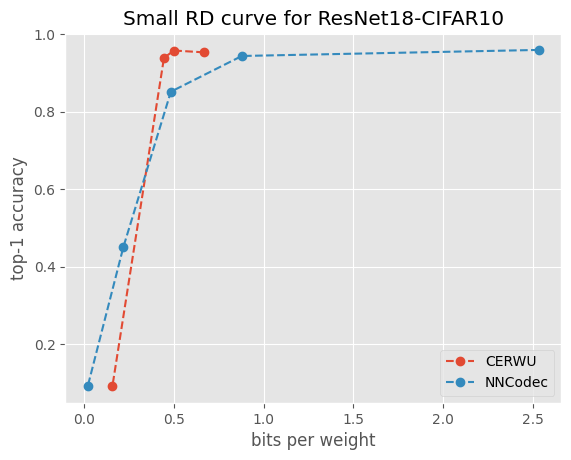

In [7]:
plt.plot(bitrates, accuracy, "--o", label="CERWU")
plt.plot(bitrates_nnc, accuracy_nnc, "--o", label="NNCodec")
plt.xlabel("bits per weight")
plt.ylabel("top-1 accuracy")
plt.title("Small RD curve for ResNet18-CIFAR10")
plt.legend()